Classification of Water Consumption Types


In [44]:

###########################
# data libraries
###########################
import pandas as pd
import numpy as np

###########################
# plot libraries
###########################
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

###########################
# Learn Libraries
###########################
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

###########################
# Neural Networks Libraries
###########################
import torch
import torch.nn as nn
import torch.nn.functional as F

print("Torch Version: ", torch.__version__)
print("Cuda is available: ", torch.cuda.is_available)
###########################
# import csv in dataframe
###########################

train = pd.read_csv("train.csv")
test = pd.read_csv("competition.csv")

###########################
# see main data features
###########################
train.info()
train.head()

Torch Version:  2.1.0+cpu
Cuda is available:  <function is_available at 0x0000023D9B4827A0>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329975 entries, 0 to 329974
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Year               329975 non-null  int64 
 1   Month              329975 non-null  int64 
 2   Consumer_type      329975 non-null  object
 3   Consumption        329975 non-null  int64 
 4   Consumer_number    329975 non-null  object
 5   Installation_zone  329975 non-null  object
dtypes: int64(3), object(3)
memory usage: 15.1+ MB


,Year,Month,Consumer_type,Consumption,Consumer_number,Installation_zone
0,2013,1,domestic,0,MOGV36480546611521,Installation_zone 1
1,2013,1,industrial,5,BECS02817768252637,Installation_zone 2
2,2013,1,domestic,6,VRFW65577141436242,Installation_zone 2
3,2013,1,domestic,1,QLLI18662653137621,Installation_zone 2
4,2013,1,domestic,13,HYUO61823402850645,Installation_zone 2


Show the correlations of some features

In [45]:
###########################
# plot to find some correlation
# or outliers
###########################
train['Installation_zone'] = pd.Categorical(train['Installation_zone'])
train['Installation_zone_code'] = train['Installation_zone'].cat.codes

train['Consumer_type'] = pd.Categorical(train['Consumer_type'])
train['Consumer_type_code'] = train['Consumer_type'].cat.codes

# sns.pairplot(data=train,x_vars=['Year', 'Month','Consumption','Installation_zone_code'], y_vars=['Year', 'Month','Consumption','Installation_zone_code'], hue='Consumer_type')
# # correlation between installation zone and consumption
# plt.figure(figsize=(15, 6))
# sns.scatterplot(data=train, x='Installation_zone',y='Consumption')

# # correlation between consumer type and consumption
# plt.figure(figsize=(15, 6))
# sns.scatterplot(data=train, x='Consumer_type',y='Consumption')

# # distribution of consumption over consumer type
# plt.figure(figsize=(10,6))
# sns.boxplot(data=train, x="Consumption", y="Consumer_type")

# # counting how much users there are in an installation zone
# # grouped by consumer type
# plt.figure(figsize=(15, 6))
# sns.histplot(data=train, x='Installation_zone',hue='Consumer_type',multiple="stack")

###########################
# we can see how more higher value of consumption generally correspond to
# an industrual consumer type, and generally correspond to an installation
# zone with a lower number
###########################


remove the single value with water consumption of 5000 because it could create some problem during the training of the model

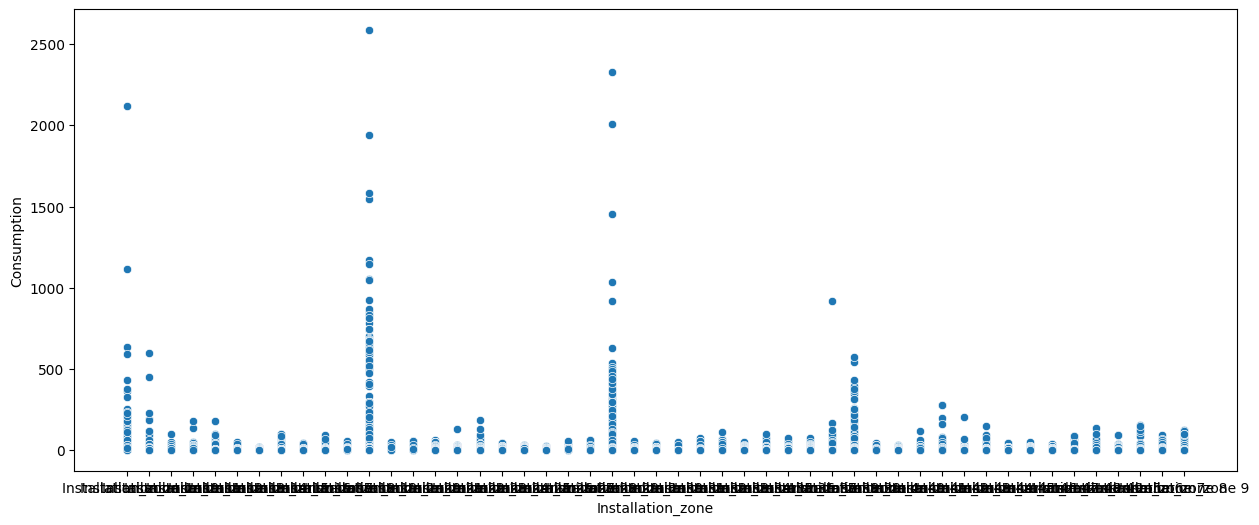

In [46]:
train_outliers = train['Consumption'] > 3000

# remove outliers
train.drop(train[train_outliers].index,inplace=True)
train.head()

# plot new
plt.figure(figsize=(15, 6))
fig = sns.scatterplot(data=train, x='Installation_zone',y='Consumption')

Now, separate the dataset in dataloaders

In [47]:


y = train['Consumer_type_code']
x = train[['Year', 'Month','Consumption','Installation_zone_code']]
x_test, x_train, y_test, y_train = train_test_split(x, y, test_size=0.2)

X_train=torch.FloatTensor(x_train.values)
X_test=torch.FloatTensor(x_test.values)
Y_train=torch.IntTensor(y_train.values)
Y_test=torch.IntTensor(y_test.values)

class ANN_model(nn.Module):
    def __init__(self):
        super(ANN_model, self).__init__()
        self.linear_ann_stack = nn.Sequential(
            nn.Linear(4, 8),
            nn.Sigmoid(),
            nn.Linear(8, 8),
            nn.Sigmoid(),
            nn.Linear(8, 7),
            nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.linear_ann_stack(x)
        return logits

First we can try to train our model with Cross Entropy Loss and the Adam optmizer

In [48]:
torch.manual_seed(20)
model = ANN_model()

model.parameters

<bound method Module.parameters of ANN_model(
  (linear_ann_stack): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=8, out_features=7, bias=True)
    (5): Sigmoid()
  )
)>

In [49]:
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

epochs=1000
train_losses=[]
for i in range(epochs):
    i= i+1
    y_pred=model.forward(X_train)
    loss=criterion(y_pred,Y_train)
    train_losses.append(loss)
    if i % 10 == 1:
        print("Epoch number: {} and the loss : {}".format(i,loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 

AttributeError: module 'torch' has no attribute '_utils'

Our loss curve is below

In [ ]:
tensor1 = torch.tensor(train_losses,requires_grad=True)
plt.plot(tensor1.detach().numpy())
plt.ylabel('Loss')
plt.show()